In [2]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
path = "/Users/howard_willard/Desktop/TESS_Cluster_Age_ML-main/"

data=Table.read(path+'data/Stats_Table_For_Data_augmented_lcs_v2.fits', format='fits')
sector_stitched=Table.read(path+'data/Stats_Table_For_Sector_Stitched.fits', format='fits')

data = vstack([data, sector_stitched])

cluster_data = data
data

name,Lit_Clst_Age,rms,std,MAD,sigmaG,skewness,von_neumann_ratio,J_Stetson,max_power,freq_at_max_power,n_peaks,ratio_of_power_at_high_v_low_freq,FAP,max_autocorrelation,time_of_max_autocorrelation,SumLSP_10_7_Day_Power,SumLSP_7_4_Day_Power,SumLSP_4_1_Day_Power,SumLSP_1_p5_Day_Power,Entropy
bytes17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64[1],float64,float64,float64,float64,float64
NGC 5381,8.65,0.2022739754519168,0.00028663242586913503,0.00018204904335616945,0.00027032716740019386,-5.109964804222913e-12,0.00386747638646434,11.012043362402764,0.2956196136312983,2.1800000000000006,7,35.25172608498783,5.6489191125891904e-83,0.6090280071896582,0.5000039539129375,0.08840027872050202,0.551564524378355,1.1235926764590056,0.2938252007400544,0.00912773133976864
NGC 5381,8.65,0.12860581353173967,0.00029758624459087497,0.00018677990032528458,0.0002724429021247358,-1.4861178185896828e-11,0.0072174287439932296,11.19932586798964,0.2858757168806013,2.1800000000000006,2,22.58421369093873,3.1991008561289327e-38,0.35192202026737984,0.5000117633198897,0.08236173981181749,0.8858419453379427,2.1146489663557895,0.6387350704087281,0.009878216867509258
NGC 5381,8.65,0.2022739754519168,0.0002749497473011351,0.0001760566489865667,0.0002598061826987392,4.985244439169258e-12,0.008432348981660785,10.832836728495531,0.3321170484680969,2.1800000000000006,2,63.9392138272648,1.7081151810643954e-46,0.6090280071896582,0.5000039539129375,0.24075422793919207,1.6594671516063568,2.1257999401516057,0.448080689756279,-0.0007504855277406172
NGC 5381,8.65,0.13418989839761541,0.00029670974388146205,0.00018715823279225052,0.00027474567848145,-1.4819021191571437e-11,0.007902359972537888,11.215158743038272,0.3092047888317955,2.1900000000000004,2,22.086456566940438,3.976387179616506e-37,0.35367954438974186,0.4791779375589158,0.09887134140967274,1.1529494497686852,2.490978861040854,0.6349831324113722,0.006366704374634439
NGC 5381,8.65,0.17262428678829597,0.0002957994551170428,0.0001947926770065056,0.00028877667424492826,7.949348591748663e-12,0.007853282537324254,11.344726858798873,0.2823310089408097,2.1800000000000006,3,25.45485685062133,5.270363097162563e-33,0.44152498501025716,0.6875159881769832,0.06948436182961143,0.8943645304859869,2.617654265447661,0.8130747500049615,0.002130485780783362
NGC 5381,8.65,0.20342537128083304,0.0002732158088483212,0.00017971636228852894,0.0002662374500090785,4.074129139791262e-12,0.007349842456913631,10.283775613193056,0.3538975416671665,2.1800000000000006,4,36.69742716441359,2.390364865023084e-44,0.5316360879383262,0.43750944667317526,0.0949982493524582,0.4623089900428734,2.053662679896389,1.046635427882411,0.0028261693332049306
NGC 5381,8.65,0.2307399119235911,0.0002677956171043393,0.00018059586669483263,0.0002665594344778601,4.8205018650938374e-12,0.007782358681751355,10.123885193997234,0.3386046778402443,2.1900000000000004,6,44.498114854025175,9.393056151242283e-42,0.47518645396899706,0.4375085258229774,0.05300589586641587,0.29486004971296664,2.174814315902417,1.095353559280317,-0.0043037936123419135
NGC 5381,8.65,0.22077649622315093,0.00028736928263985265,0.00019529854088140564,0.0002865572846073615,3.3188360954961803e-12,0.008793630554351822,10.922918396661096,0.27925708595394183,2.1900000000000004,6,52.40948815416692,2.0673842635311304e-32,0.6002905113611597,0.5000039539129375,0.24813217870249696,1.2957295189420075,2.28049676322127,0.8465257783128015,0.007883061859175302
NGC 5381,8.65,0.21821100221255357,0.0002979377559200514,0.0002010363813400584,0.00029422255247299917,3.048307924578792e-12,0.00967834794471458,11.503733919463457,0.29776047325346133,0.22000000000000006,3,61.22050634304591,2.696162426828419e-35,0.60816054645364,0.5000039539129375,0.32120520102402084,2.126809469890936,2.186733635251189,0.8440061976224885,0.0003633584417250379


In [122]:

def add_uniform_noise(y, low=-0.05, high=0.05):
    return y + (torch.rand(y.shape) * (high - low) + low)

def get_samples(data, size=35):
    grouped = data.group_by('name')
    total_groups = len(grouped.groups)
    
    # Ensure size is valid
    if size * 2 >= total_groups:
        raise ValueError("Size is too large relative to the number of groups.")
    
    # Randomly sample indices
    possible_indices = np.arange(total_groups)
    validation_indices = np.random.choice(possible_indices, size=size, replace=False)
    remaining_indices = np.setdiff1d(possible_indices, validation_indices)
    test_indices = np.random.choice(remaining_indices, size=size, replace=False)
    training_indices = np.setdiff1d(remaining_indices, test_indices)
    
    # Stack data
    training_data = vstack([grouped.groups[i] for i in training_indices])
    validation_data = vstack([grouped.groups[i] for i in validation_indices])
    test_data = vstack([grouped.groups[i] for i in test_indices])
    
    # Define feature columns
    feature_cols = ['rms', 'std', 'MAD', 'sigmaG', 'skewness', 'von_neumann_ratio',
                    'J_Stetson', 'max_power', 'freq_at_max_power', 'ratio_of_power_at_high_v_low_freq',
                    'max_autocorrelation', 'time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power',
                    'SumLSP_7_4_Day_Power', 'SumLSP_4_1_Day_Power', 'SumLSP_1_p5_Day_Power', 'Entropy']
    
    # Convert to NumPy arrays
    X_train = np.column_stack([training_data[col].reshape(-1, 1) for col in feature_cols])
    X_valid = np.array([validation_data[col].reshape(-1, 1) for col in feature_cols]).T
    X_test = np.array([test_data[col].reshape(-1, 1) for col in feature_cols]).T

    # This is now for continuous prediction
    y_mean = np.mean(training_data['Lit_Clst_Age'])
    y_train = training_data['Lit_Clst_Age'] - y_mean
    y_valid = validation_data['Lit_Clst_Age'] - y_mean
    y_test = test_data['Lit_Clst_Age'] - y_mean
    
    #fix the shapes
    X_valid = np.squeeze(X_valid)
    X_test = np.squeeze(X_test)
    
    # Scale the data for the NN
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)
    
    # Convert all to a tensor
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_valid = torch.tensor(X_valid, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(np.asarray(y_train), dtype=torch.float32).view(-1, 1)
    y_valid = torch.tensor(np.asarray(y_valid), dtype=torch.float32).view(-1, 1)
    y_test = torch.tensor(np.asarray(y_test), dtype=torch.float32).view(-1, 1)

    #Try smoothign the data?
    y_train = add_uniform_noise(y_train)
    y_valid = add_uniform_noise(y_valid)
    y_test  = add_uniform_noise(y_test)
        

    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, feature_cols, y_mean

X_train, X_valid, X_test, y_train, y_valid, y_test, feature_cols, y_mean = get_samples(cluster_data)

print("X_train: ", np.shape(X_train))
print("X_valid: ", np.shape(X_valid))
print("X_test: ", np.shape(X_test))
print("y_train: ", np.shape(y_train))
print("y_valid: ", np.shape(y_valid))
print("y_test: ", np.shape(y_test))
print("feature_cols: ", feature_cols)

X_train.shape


X_train:  torch.Size([37954, 17])
X_valid:  torch.Size([5240, 17])
X_test:  torch.Size([4043, 17])
y_train:  torch.Size([37954, 1])
y_valid:  torch.Size([5240, 1])
y_test:  torch.Size([4043, 1])
feature_cols:  ['rms', 'std', 'MAD', 'sigmaG', 'skewness', 'von_neumann_ratio', 'J_Stetson', 'max_power', 'freq_at_max_power', 'ratio_of_power_at_high_v_low_freq', 'max_autocorrelation', 'time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power', 'SumLSP_7_4_Day_Power', 'SumLSP_4_1_Day_Power', 'SumLSP_1_p5_Day_Power', 'Entropy']


torch.Size([37954, 17])

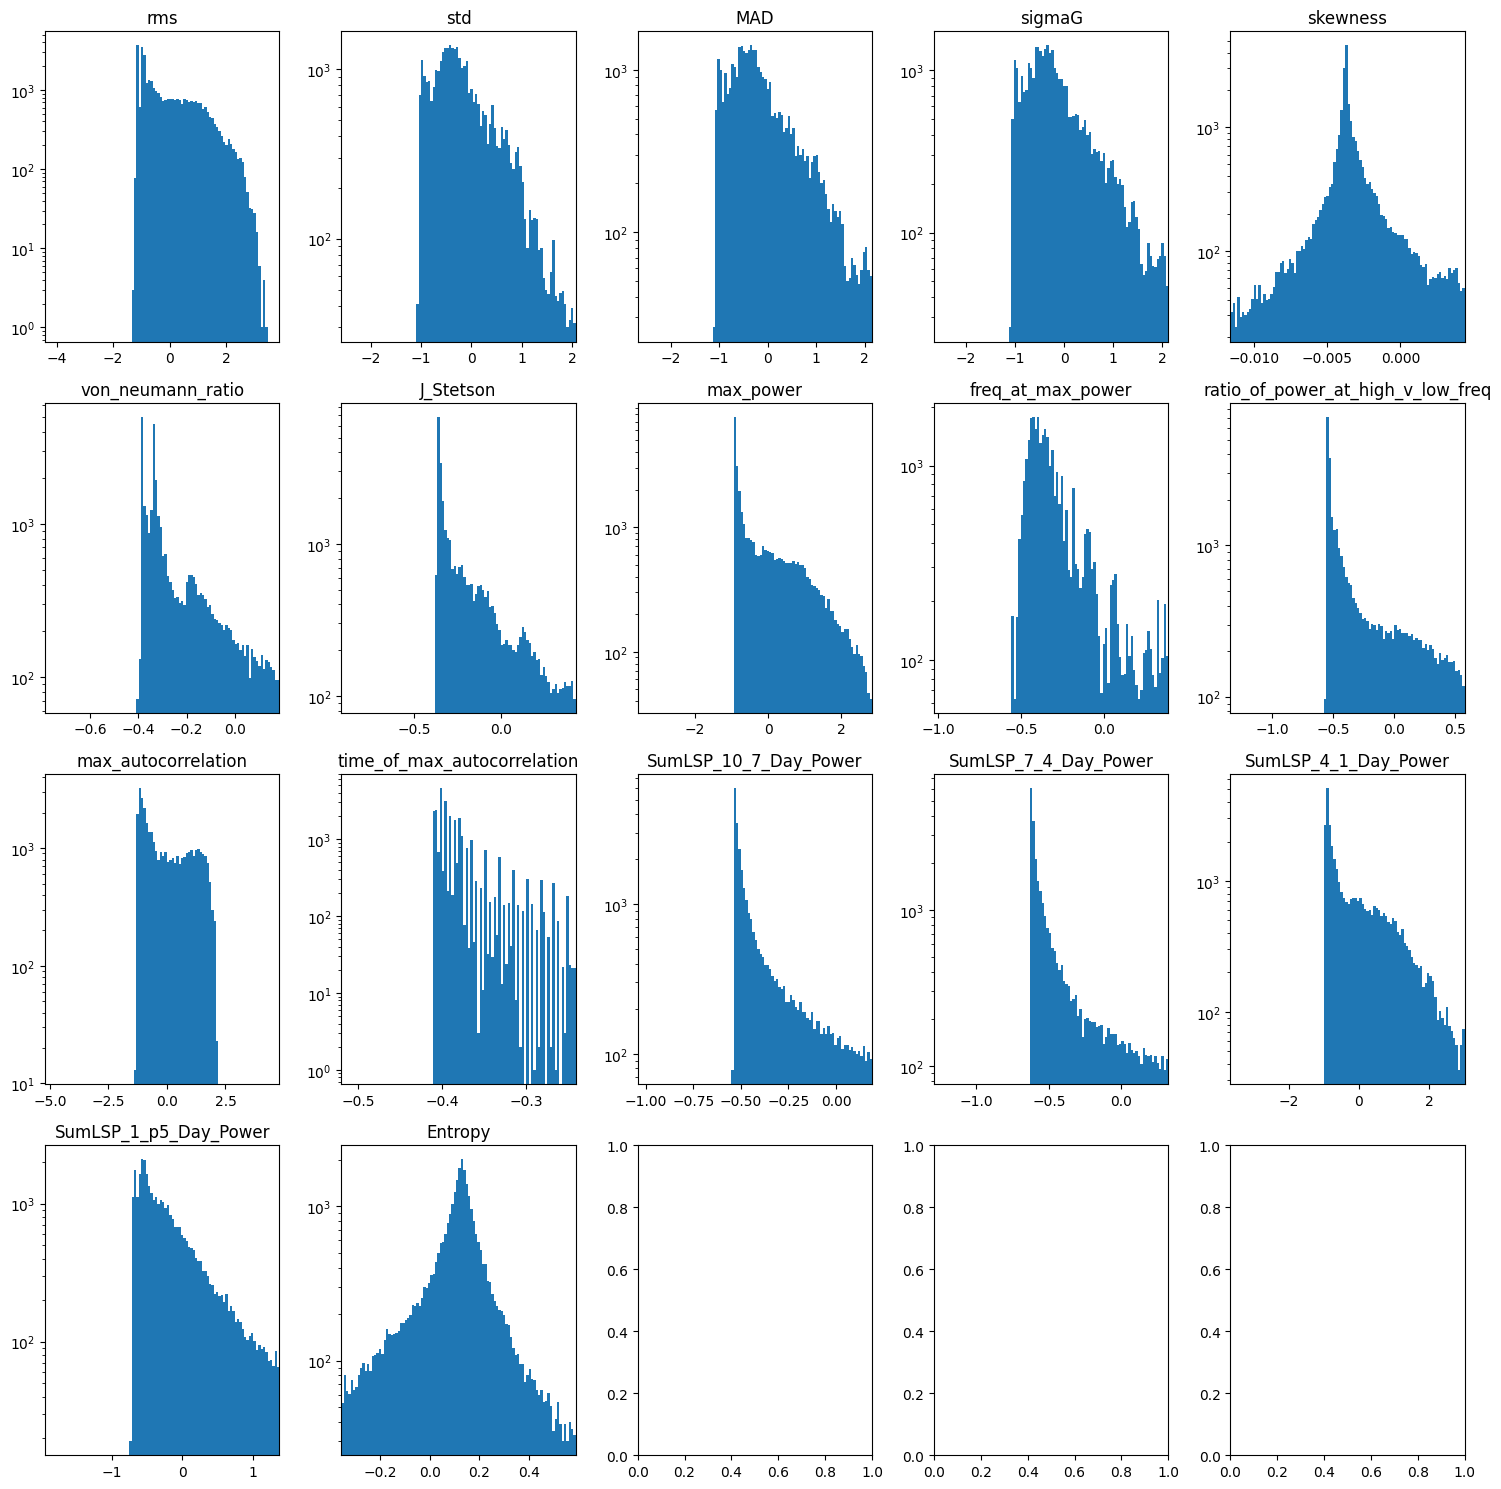

In [5]:
# Full histogram illustrating the data:

fig, axs = plt.subplots(4, 5, figsize=(15,15))
data = X_train

for index, col in enumerate(feature_cols):
    i = index // 5
    j = index % 5
    #print(i, j, col)
    median = np.nanmedian(data[:, index])  # Ignore NaNs
    mad = np.nanmedian(np.abs(data[:, index] - median))  # Compute MAD
    scale_factor = 1.4826  # Approximate conversion to std deviation
    lower_bound = median - 4 * scale_factor * mad
    upper_bound = median + 4 * scale_factor * mad
    
    axs[i, j].hist(data[:, index], bins=100, range=(lower_bound, upper_bound))
    axs[i, j].set_title(col)
    axs[i, j].set_yscale('log')
    axs[i, j].set_xlim([lower_bound, upper_bound])

plt.tight_layout()
plt.show()

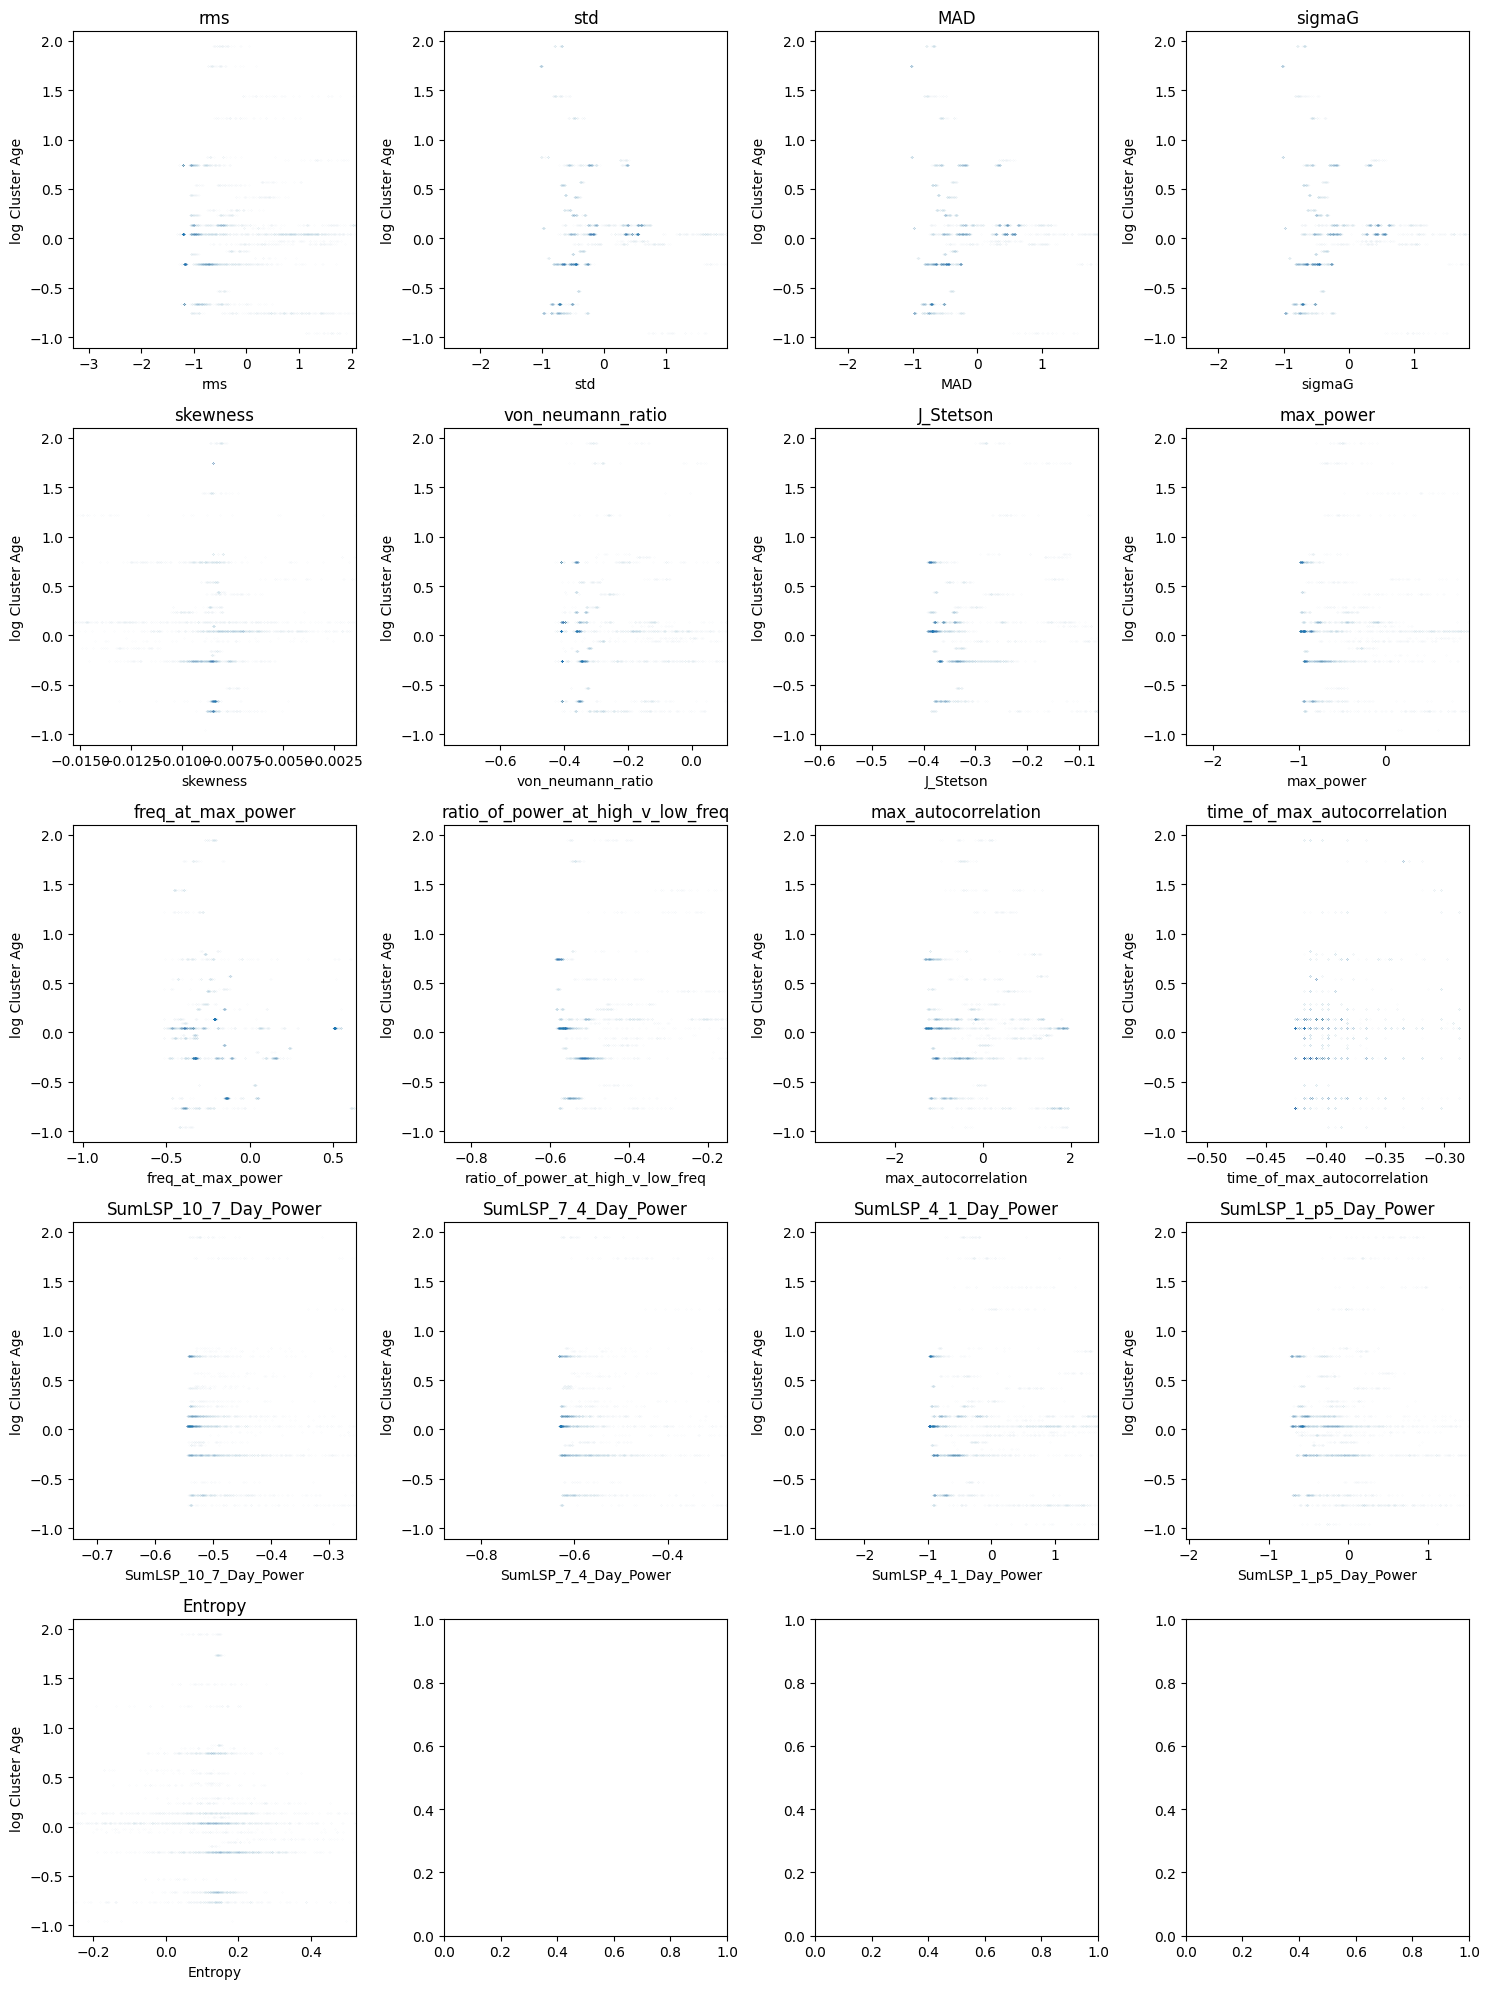

In [114]:
# Full histogram illustrating the data:

fig, axs = plt.subplots(5, 4, figsize=(15,20))

data = X_valid
data_y = y_valid
for index, col in enumerate(feature_cols):
    i = index // 4
    j = index % 4
    #print(i, j, col)
    median = np.nanmedian(data[:, index])  # Ignore NaNs
    mad = np.nanmedian(np.abs(data[:, index] - median))  # Compute MAD
    scale_factor = 1.4826  # Approximate conversion to std deviation
    lower_bound = median - 4 * scale_factor * mad
    upper_bound = median + 4 * scale_factor * mad
    
    axs[i, j].scatter(data[:, index], data_y, s=0.01, alpha=0.1)
    axs[i, j].set_title(col)
    #axs[i, j].set_yscale('log')
    axs[i, j].set_xlim([lower_bound, upper_bound])
    axs[i, j].set_xlabel(col)
    axs[i, j].set_ylabel('log Cluster Age')

plt.tight_layout()
plt.show()

# Define The Models

### Models W/O Uncertainty

In [115]:
import torch
import torch.nn as nn
import torch.nn.init as init

class FlexibleNN(nn.Module):
    def __init__(self, input_dim, layer_dims, activation_fn="relu", init_method="xavier", dropout_rate=0.0, use_batchnorm=False):
        """
        A flexible feedforward neural network with optional batch normalization and dropout.

        Parameters:
            input_dim (int): Number of input features.
            layer_dims (list of int): List of neuron counts for each hidden layer. The last value is the output layer size.
            activation_fn (str): Activation function ("relu", "tanh", "sigmoid", "leaky_relu", "none").
            init_method (str): Weight initialization method ("xavier", "kaiming", "small_random", "orthogonal", "hybrid").
            dropout_rate (float): Dropout probability (0.0 means no dropout).
            use_batchnorm (bool): If True, applies Batch Normalization after each Linear layer.
        """
        super(FlexibleNN, self).__init__()

        self.layers = nn.ModuleList()
        self.batchnorms = nn.ModuleList() if use_batchnorm else None
        self.dropouts = nn.ModuleList() if dropout_rate > 0 else None
        self.activation_fn = activation_fn.lower()
        self.init_method = init_method.lower()
        self.use_batchnorm = use_batchnorm
        self.dropout_rate = dropout_rate

        prev_dim = input_dim
        for i, dim in enumerate(layer_dims):
            self.layers.append(nn.Linear(prev_dim, dim))
            if use_batchnorm:
                self.batchnorms.append(nn.BatchNorm1d(dim))
            if dropout_rate > 0:
                self.dropouts.append(nn.Dropout(p=dropout_rate))
            prev_dim = dim

        # Apply weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Custom weight initialization function."""
        if isinstance(m, nn.Linear):
            if self.init_method == "kaiming":
                init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif self.init_method == "xavier":
                init.xavier_normal_(m.weight)
            elif self.init_method == "small_random":
                init.normal_(m.weight, mean=0.0, std=0.01)
            elif self.init_method == "orthogonal":
                init.orthogonal_(m.weight)
            elif self.init_method == "hybrid":
                # Hybrid initialization: Kaiming for hidden layers, Xavier for output
                if m in self.layers[:-1]:
                    init.kaiming_normal_(m.weight, nonlinearity="relu")
                else:
                    init.xavier_normal_(m.weight)

            init.zeros_(m.bias)  # Initialize biases to zero

    def forward(self, x):
        """Forward pass through the network."""
        for i, layer in enumerate(self.layers[:-1]):  # All layers except last
            x = layer(x)
            if self.use_batchnorm:
                x = self.batchnorms[i](x)
            x = self._apply_activation(x)
            if self.dropout_rate > 0:
                x = self.dropouts[i](x)

        x = self.layers[-1](x)  # Output layer (no activation)
        return x

    def _apply_activation(self, x):
        """Applies the chosen activation function."""
        if self.activation_fn == "relu":
            return torch.relu(x)
        elif self.activation_fn == "tanh":
            return torch.tanh(x)
        elif self.activation_fn == "sigmoid":
            return torch.sigmoid(x)
        elif self.activation_fn == "leaky_relu":
            return torch.nn.functional.leaky_relu(x, negative_slope=0.01)
        return x  # No activation if "none"


# Example usage
params = {
    "input_dim": 10,
    "layer_dims": [128, 64, 1],  # Hidden layers + output
    "activation_fn": "relu",
    "init_method": "xavier",
    "dropout_rate": 0.2,  # 20% dropout
    "use_batchnorm": True  # Enable Batch Normalization
}

model = FlexibleNN(**params)
print(model)


FlexibleNN(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (batchnorms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropouts): ModuleList(
    (0-2): 3 x Dropout(p=0.2, inplace=False)
  )
)


hi
Training model 1/3 with 10 trials
Trial 1/10
    Epoch 1/200, Training Loss: 0.4546, Validation Loss: 0.3302
    Epoch 11/200, Training Loss: 0.2996, Validation Loss: 0.2283
    Epoch 21/200, Training Loss: 0.2684, Validation Loss: 0.2170
    Epoch 31/200, Training Loss: 0.2534, Validation Loss: 0.2005
    Epoch 41/200, Training Loss: 0.2434, Validation Loss: 0.2052
    Epoch 51/200, Training Loss: 0.2353, Validation Loss: 0.1962
    Epoch 61/200, Training Loss: 0.2284, Validation Loss: 0.1922
    Epoch 71/200, Training Loss: 0.2219, Validation Loss: 0.1885
    Epoch 81/200, Training Loss: 0.2158, Validation Loss: 0.1860
    Epoch 91/200, Training Loss: 0.2099, Validation Loss: 0.1834
    Epoch 101/200, Training Loss: 0.2044, Validation Loss: 0.1802
    Epoch 111/200, Training Loss: 0.1993, Validation Loss: 0.1775
    Epoch 121/200, Training Loss: 0.1944, Validation Loss: 0.1761
    Epoch 131/200, Training Loss: 0.1897, Validation Loss: 0.1743
    Epoch 141/200, Training Loss: 0.185

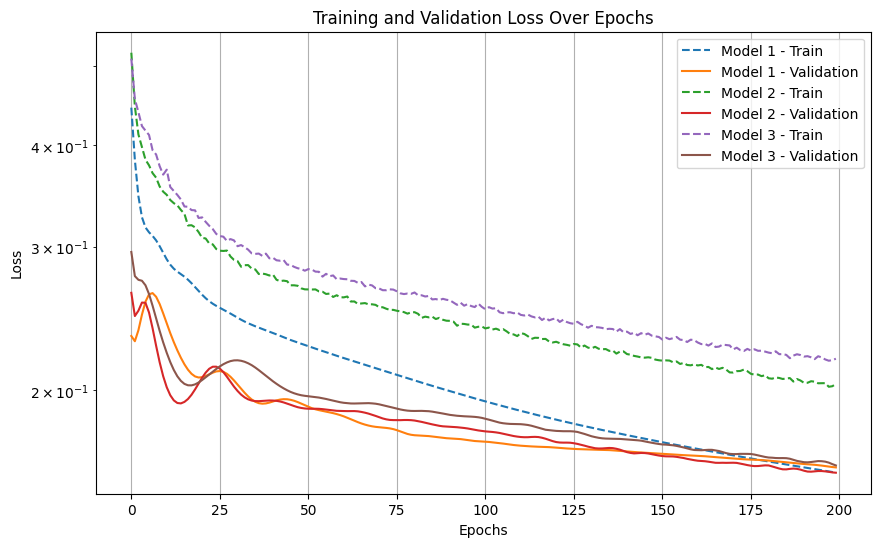

In [140]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt



# Function to train a single model and track losses and validation errors
def train_single_model(model, X_train, y_train, X_valid, y_valid, n_epochs=200, lr=0.001, loss_fn=None, plot_results=False):
    """
    Trains a single model and tracks its loss and validation errors over epochs.
    
    Parameters:
        model: The model to train.
        X_train, y_train: Training data and labels.
        X_valid, y_valid: Validation data and labels.
        n_epochs (int): Number of training epochs.
        lr (float): Learning rate.
        loss_fn: Loss function to use (e.g., MSELoss, etc.).
        plot_results (bool): Whether to plot the training and validation losses.
        
    Returns:
        best_model: The best model based on validation loss.
        loss_array (numpy.ndarray): Array of training losses.
        val_loss_array (numpy.ndarray): Array of validation losses.
    """
    loss_array = np.zeros(n_epochs)
    val_loss_array = np.zeros(n_epochs)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    best_val_loss = float("inf")
    best_model = None

    # Training loop for a single model
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Validation loss
        model.eval()
        with torch.no_grad():
            y_valid_pred = model(X_valid)
            val_loss = loss_fn(y_valid_pred, y_valid).item()

        # Track losses
        loss_array[epoch] = loss.item()
        val_loss_array[epoch] = val_loss

        # Update best model if necessary
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

        if epoch % 10 == 0:
            print(f"    Epoch {epoch+1}/{n_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

    # Optionally plot the training and validation losses
    # if plot_results:
    #     plot_training_loss(loss_array, val_loss_array)

    return best_model, loss_array, val_loss_array

def train_multiple_models(model_architectures, X_train, y_train, X_valid, y_valid, n_epochs=200, lr=0.001, loss_fn=None, plot_results=False, n_trials=1):
    """
    Trains multiple models and tracks their losses and validation errors over epochs.
    Each model is trained multiple times (n_trials), and only the best model is kept.

    Parameters:
        models (list): List of model instances to train.
        X_train, y_train: Training data and labels.
        X_valid, y_valid: Validation data and labels.
        n_epochs (int): Number of training epochs.
        lr (float): Learning rate.
        loss_fn: Loss function to use.
        plot_results (bool): Whether to plot the training and validation losses.
        n_trials (int): Number of trials to run for each model, the best performing model is kept.

    Returns:
        best_models (list): List of best models for each model definition after n_trials.
        loss_arrays (numpy.ndarray): Array of training losses for each model.
        val_loss_arrays (numpy.ndarray): Array of validation losses for each model.
    """
    trained_models = []
    loss_arrays = []
    val_loss_arrays = []

    for i, model_params in enumerate(model_architectures):
        print(f"Training model {i+1}/{len(model_architectures)} with {n_trials} trials")

        # Initialize variables to track the best model over all trials
        best_trial_model = None
        best_trial_val_loss = float('inf')
        best_loss_array = None
        best_val_loss_array = None

        # Run the specified number of trials for each model
        for trial in range(n_trials):
            #print(model_params)
            model = FlexibleNN(**model_params)

            print(f"Trial {trial+1}/{n_trials}")
            trained_model, loss_array, val_loss_array = train_single_model(
                model, X_train, y_train, X_valid, y_valid, n_epochs, lr, loss_fn, plot_results=False
            )

            # Keep track of the best model based on validation loss
            final_val_loss = val_loss_array[-1]  # Get the final validation loss of the trial
            if final_val_loss < best_trial_val_loss:
                best_trial_val_loss = final_val_loss
                best_trial_model = trained_model
                best_loss_array = loss_array
                best_val_loss_array = val_loss_array

        # After all trials, append the best model and its losses
        trained_models.append(best_trial_model)
        loss_arrays.append(best_loss_array)
        val_loss_arrays.append(best_val_loss_array)

    # Optionally plot the results
    if plot_results:
        plot_training_loss(np.asarray(loss_arrays), np.asarray(val_loss_arrays))

    return trained_models, np.array(loss_arrays), np.array(val_loss_arrays)

# Function to plot the training and validation losses for all models
def plot_training_loss(training_loss, validation_loss, model_names=None):
    """
    Plots the training and validation losses for all models.
    
    Parameters:
        training_loss (numpy.ndarray): 2D array of training losses (n_models x n_epochs).
        validation_loss (numpy.ndarray): 2D array of validation losses (n_models x n_epochs).
        model_names (list of str, optional): Names of the models for labeling.
    """
    n_models, n_epochs = training_loss.shape

    plt.figure(figsize=(10, 6))

    for i in range(n_models):
        label = model_names[i] if model_names is not None else f"Model {i+1}"
        plt.plot(range(n_epochs), training_loss[i], label=f"{label} - Train", linestyle='--')
        plt.plot(range(n_epochs), validation_loss[i], label=f"{label} - Validation")

    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_final_models(models, X, Y, model_architectures, y_mean=0):
    """
    Plots the final predictions for each model, including incorrect predictions and extreme errors.
    
    Parameters:
        models (list): List of trained models to evaluate.
        X (torch.Tensor): Input data (features).
        Y (torch.Tensor): True labels (target values).
        model_names (list of str): List of model names for labeling the plots.
        y_mean (float): Mean of the target values to reverse normalization if necessary.
    """
    Y = Y.numpy().flatten()
    Y += y_mean  # Adjust if necessary (inverse normalization, etc.)
    
    if not isinstance(models, list):  # Allow single model input
        models = [models]
    
    fig, axs = plt.subplots(2, len(models), figsize=(5 * len(models), 10))  # 2 rows, N columns
    
    if len(models) == 1:
        axs = np.expand_dims(axs, axis=1)  # Ensure axs is 2D for consistency

    for i, model in enumerate(models):
        model_name = model_architectures[i]['activation_fn'] + '_' + model_architectures[i]['init_method'] + '_' + str(model_architectures[i]['layer_dims'])
        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            # Get predictions
            y_pred = model(X)
            y_pred += y_mean  # Adjust if necessary (inverse normalization, etc.)
        
        # Convert tensors to numpy arrays
        y_pred = y_pred.numpy().flatten()

        
        # Scatter plot of true vs predicted values
        axs[0, i].scatter(Y, y_pred, color='blue', alpha=0.1)        
        axs[0, i].set_title(f"{model_name}: All Predictions")
        axs[0, i].annotate(f"Mean Error: {np.mean(np.abs(y_pred - Y)):.2f}", 
                           xy=(0.05, 0.95), xycoords='axes fraction', 
                           fontsize=10, color='black', backgroundcolor='white')

        # Filter incorrect predictions (|error| > 1)
        incorrect = np.abs(y_pred - Y) > 1
        axs[1, i].scatter(Y[incorrect], y_pred[incorrect], color='blue', alpha=0.5)
        axs[1, i].set_title(f"{model_name}: Incorrect Predictions (|error| > 1)")

    # Formatting
    for ax_row in axs:
        for ax in ax_row:
            a, b = np.min(Y), np.max(Y)
            ax.plot([a, b], [a, b], color='red', linestyle='--', label="True values")
            
            ax.set_xlim([np.min(Y)-1, np.max(Y)+1])
            ax.set_ylim([np.min(Y)-1, np.max(Y)+1])
            #ax.set_yscale('log')
            ax.set_xlabel('True Values')
            ax.set_ylabel('Predicted Values')
            ax.legend()

    plt.tight_layout()
    plt.show()




# Example usage:
input_dim = X_train.shape[1]

params1 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "relu",
    "init_method": "xavier",
    "dropout_rate": 0.0,  # 20% dropout
    "use_batchnorm": False  # Enable Batch Normalization
}


params2 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "relu",
    "init_method": "xavier",
    "dropout_rate": 0.15,  # 20% dropout
    "use_batchnorm": False  # Enable Batch Normalization
}


params3 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "relu",
    "init_method": "xavier",
    "dropout_rate": 0.3,  # 20% dropout
    "use_batchnorm": False  # Enable Batch Normalization
}



model_architectures=[params1, params2, params3]

print('hi')
# Train models and plot results
models, loss_arrays, val_loss_arrays = train_multiple_models(
    model_architectures=model_architectures,
    X_train=X_train,  y_train=y_train,
    X_valid=X_valid,  y_valid=y_valid,
    n_epochs=200, lr=0.001,
    loss_fn=torch.nn.MSELoss(), #torch.nn.SmoothL1Loss(), #torch.nn.MSELoss(), #huber_loss = nn.SmoothL1Loss()
    plot_results=True,     
    n_trials=10  # Train each model 5 times, keeping the best one
)

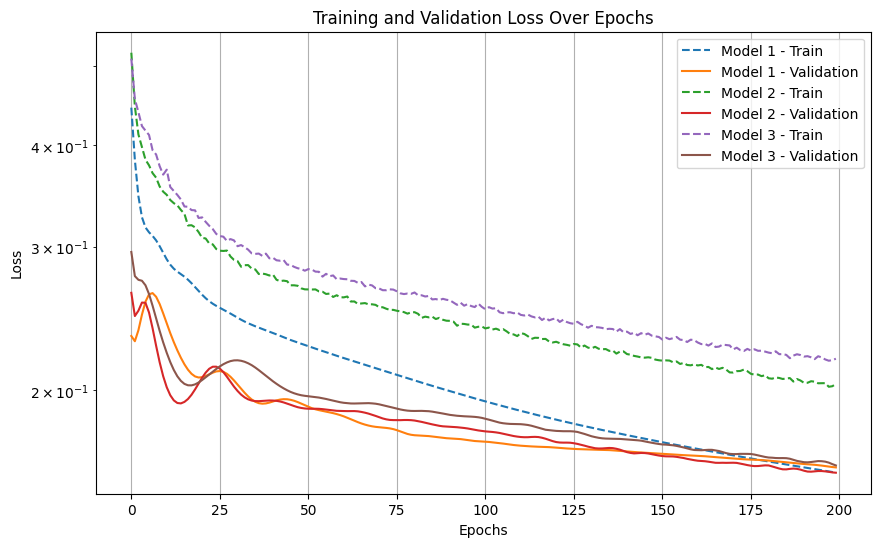

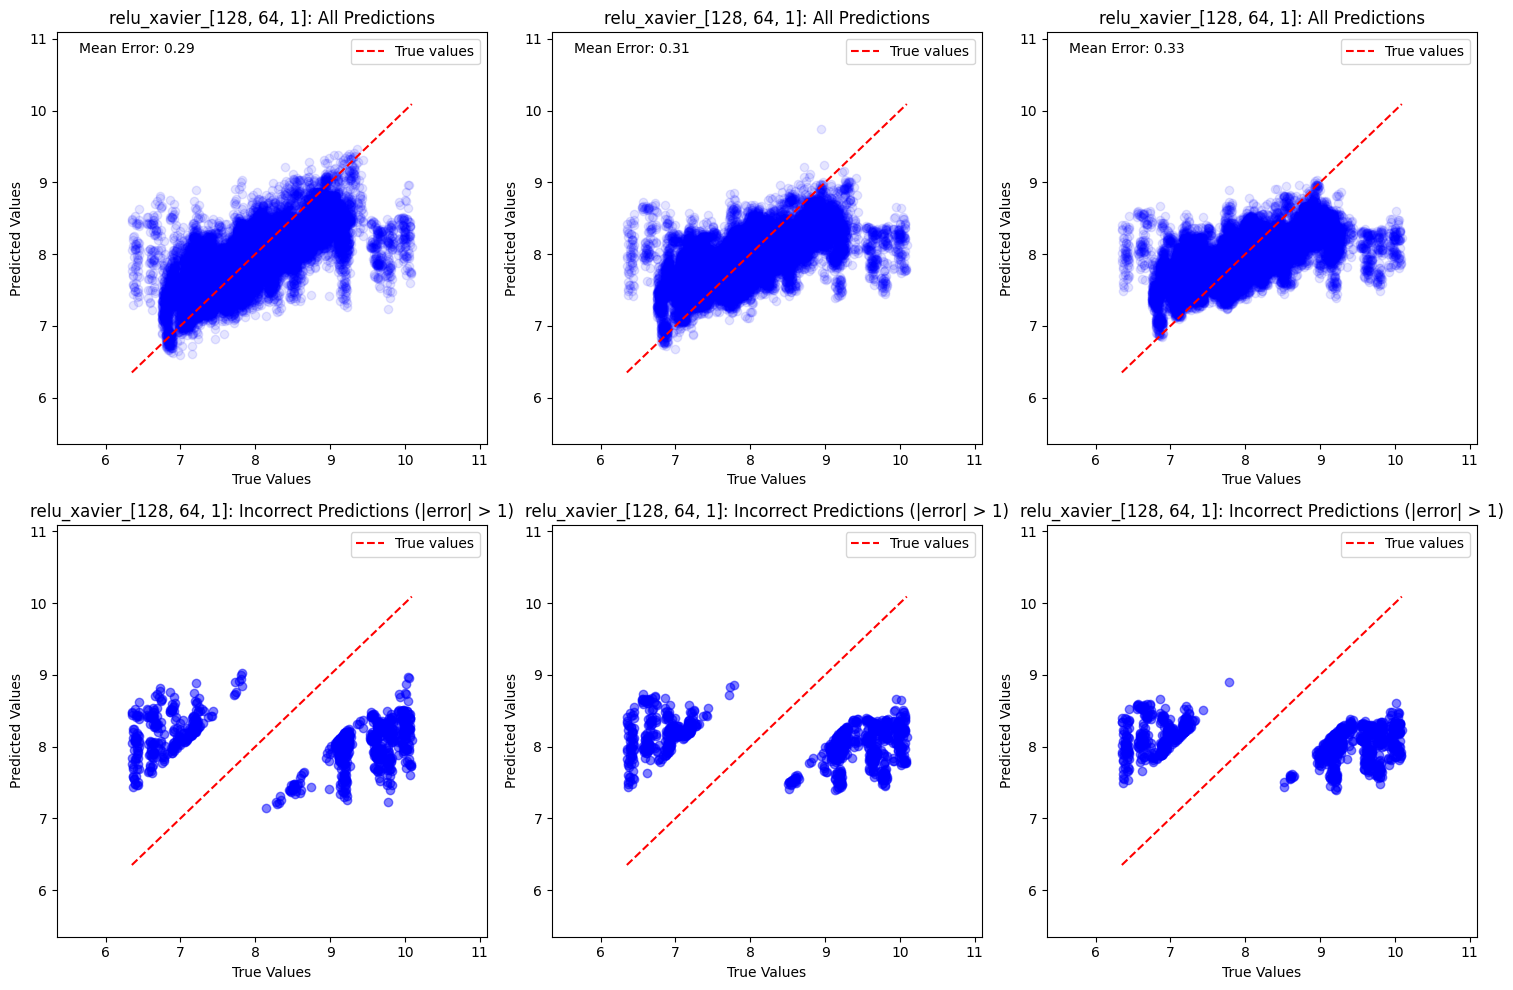

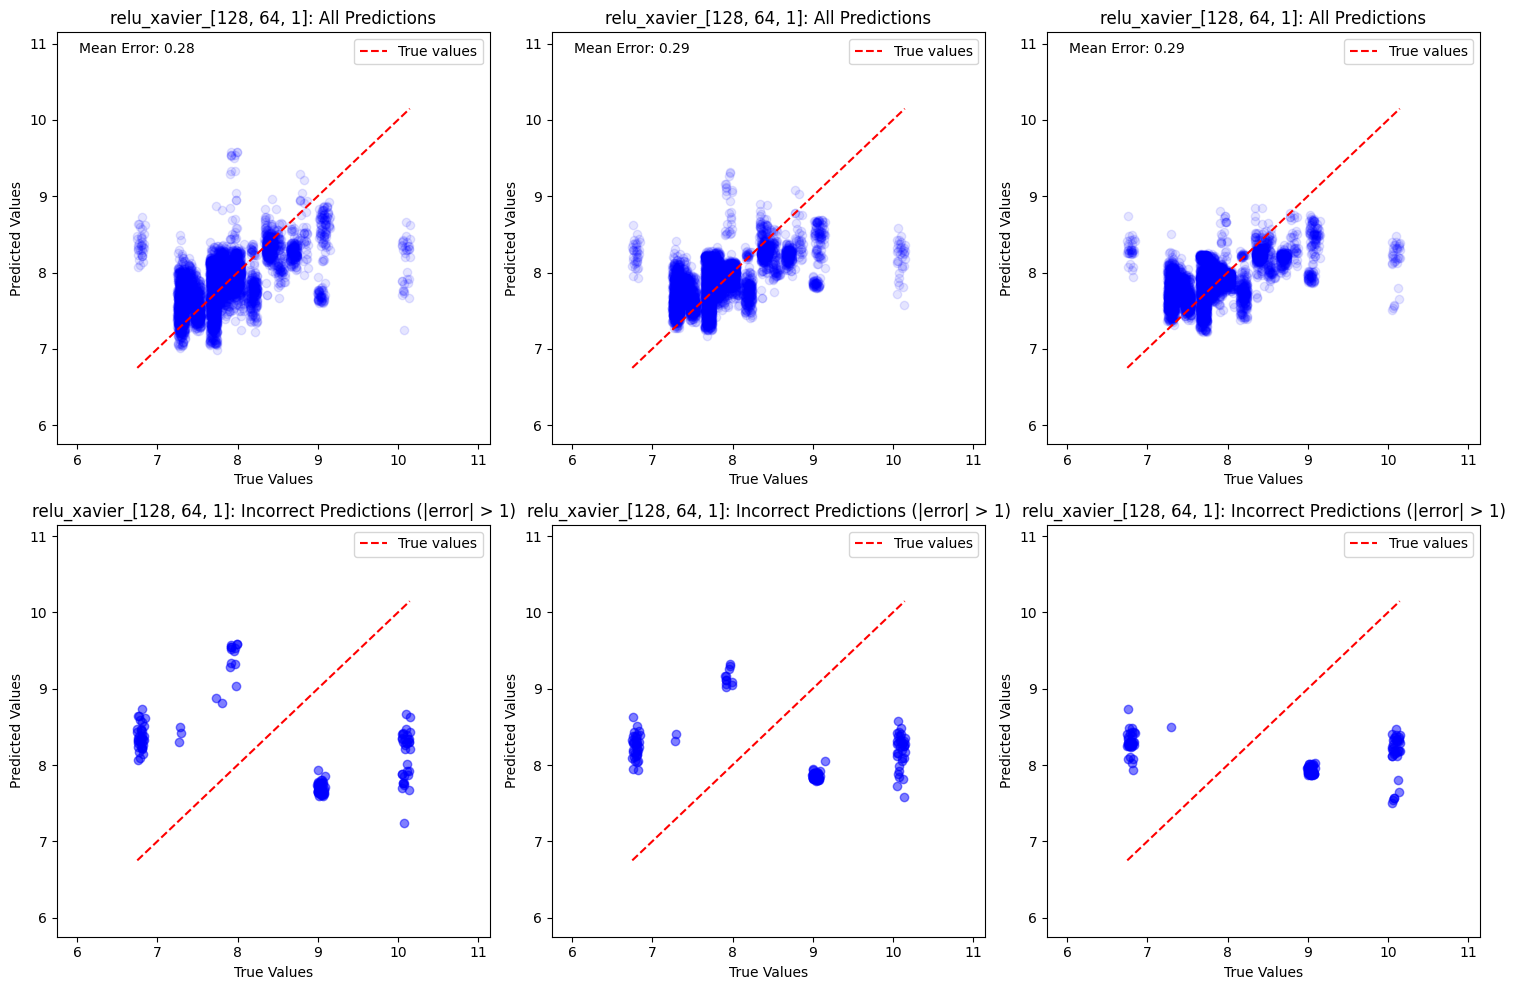

In [141]:

plot_training_loss(loss_arrays, val_loss_arrays)
plot_final_models(models, X_train, y_train, model_architectures, y_mean=y_mean)
plot_final_models(models, X_valid, y_valid, model_architectures, y_mean=y_mean)

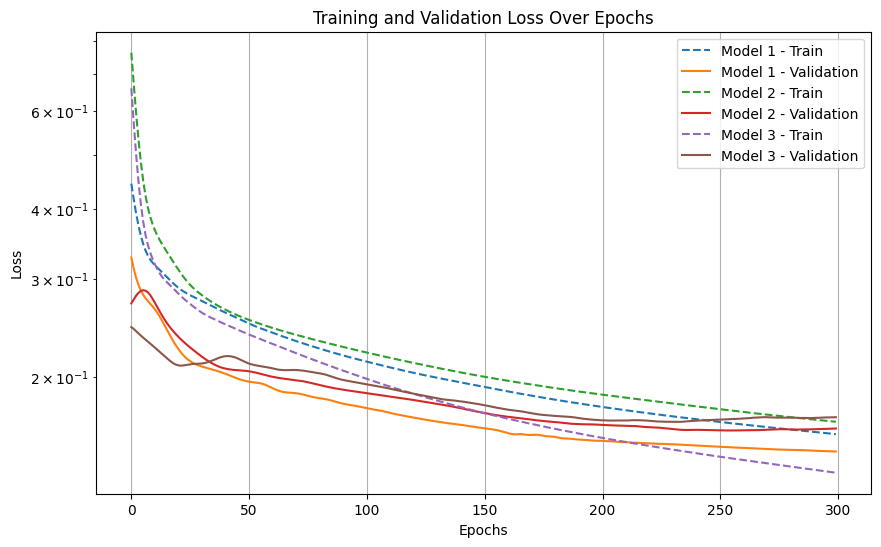

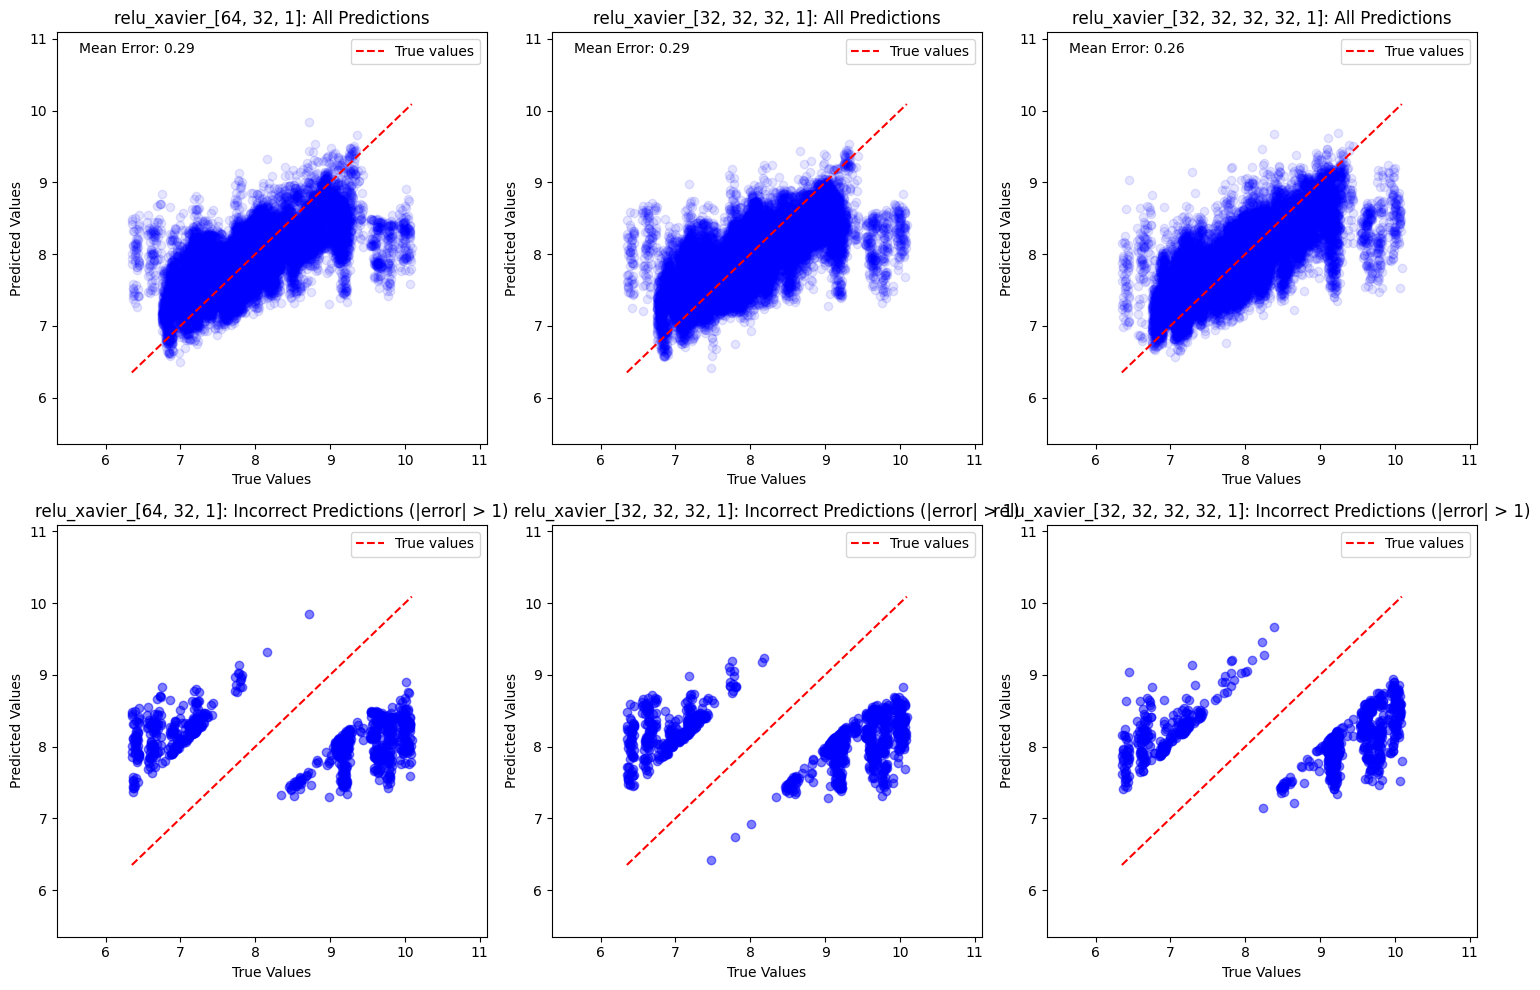

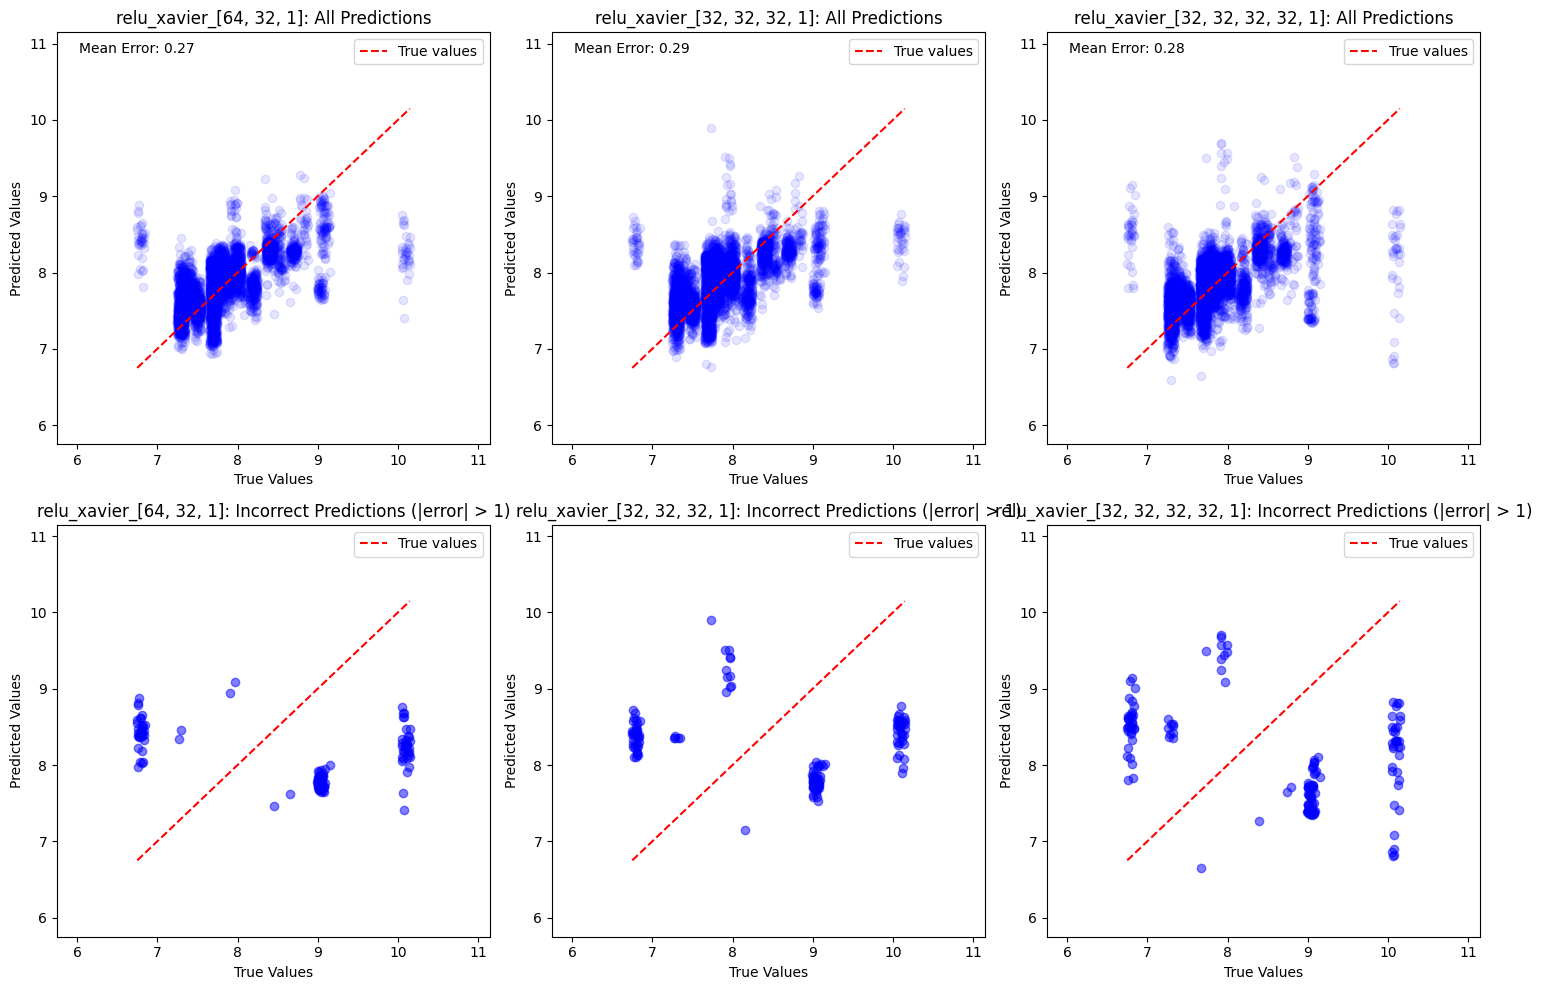

In [135]:

plot_training_loss(loss_arrays, val_loss_arrays)
plot_final_models(models, X_train, y_train, model_architectures, y_mean=y_mean)
plot_final_models(models, X_valid, y_valid, model_architectures, y_mean=y_mean)

In [75]:
str(model_architectures[i]['layer_dims'])

'[128, 64, 1]'

hi
Training model 1/4 with 10 trials
Trial 1/10
    Epoch 1/50, Training Loss: 0.3621, Validation Loss: 0.4130
Trial 2/10
    Epoch 1/50, Training Loss: 0.3497, Validation Loss: 0.4601
Trial 3/10
    Epoch 1/50, Training Loss: 0.3673, Validation Loss: 0.4697
Trial 4/10
    Epoch 1/50, Training Loss: 0.3519, Validation Loss: 0.4169
Trial 5/10
    Epoch 1/50, Training Loss: 0.3947, Validation Loss: 0.4805
Trial 6/10
    Epoch 1/50, Training Loss: 0.4608, Validation Loss: 0.4377
Trial 7/10
    Epoch 1/50, Training Loss: 0.3390, Validation Loss: 0.4119
Trial 8/10
    Epoch 1/50, Training Loss: 0.3995, Validation Loss: 0.3928
Trial 9/10
    Epoch 1/50, Training Loss: 0.3785, Validation Loss: 0.4476
Trial 10/10
    Epoch 1/50, Training Loss: 0.5587, Validation Loss: 0.5703
Training model 2/4 with 10 trials
Trial 1/10
    Epoch 1/50, Training Loss: 0.3365, Validation Loss: 0.4483
Trial 2/10
    Epoch 1/50, Training Loss: 0.3688, Validation Loss: 0.4144
Trial 3/10
    Epoch 1/50, Training Loss

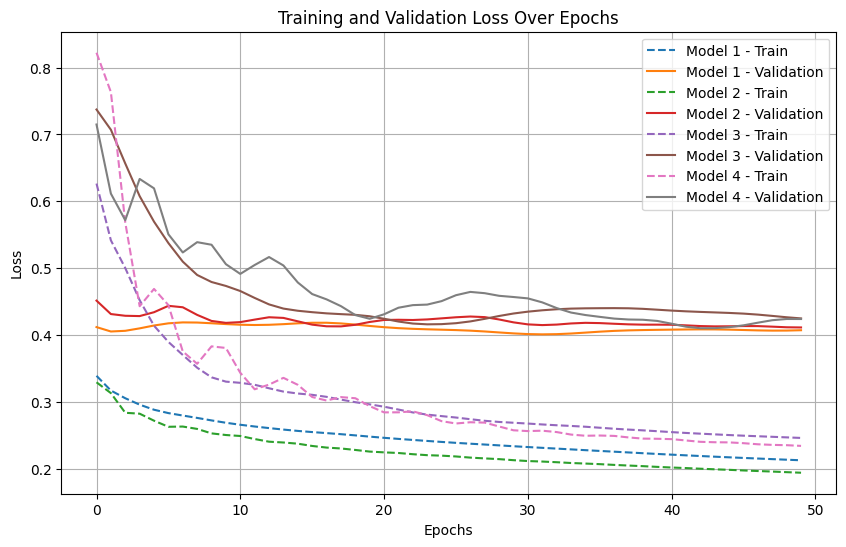

In [89]:

# Example usage:
input_dim = X_train.shape[1]

params1 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "relu",
    "init_method": "xavier",
}

params2 = {
    "input_dim": input_dim,
    "layer_dims": [256, 128, 1],
    "activation_fn": "relu",
    "init_method": "xavier",
}

params3 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "tanh",
    "init_method": "kaiming",
}

params4 = {
    "input_dim": input_dim,
    "layer_dims": [256, 128, 1],
    "activation_fn": "tanh",
    "init_method": "kaiming",
}

model_architectures=[params1, params2, params3, params4]

print('hi')
# Train models and plot results
models, loss_arrays, val_loss_arrays = train_multiple_models(
    model_architectures=model_architectures,
    X_train=X_train,  y_train=y_train,
    X_valid=X_valid,  y_valid=y_valid,
    n_epochs=50, lr=0.001,
    loss_fn=torch.nn.MSELoss(),
    plot_results=True,     
    n_trials=10  # Train each model 5 times, keeping the best one
)

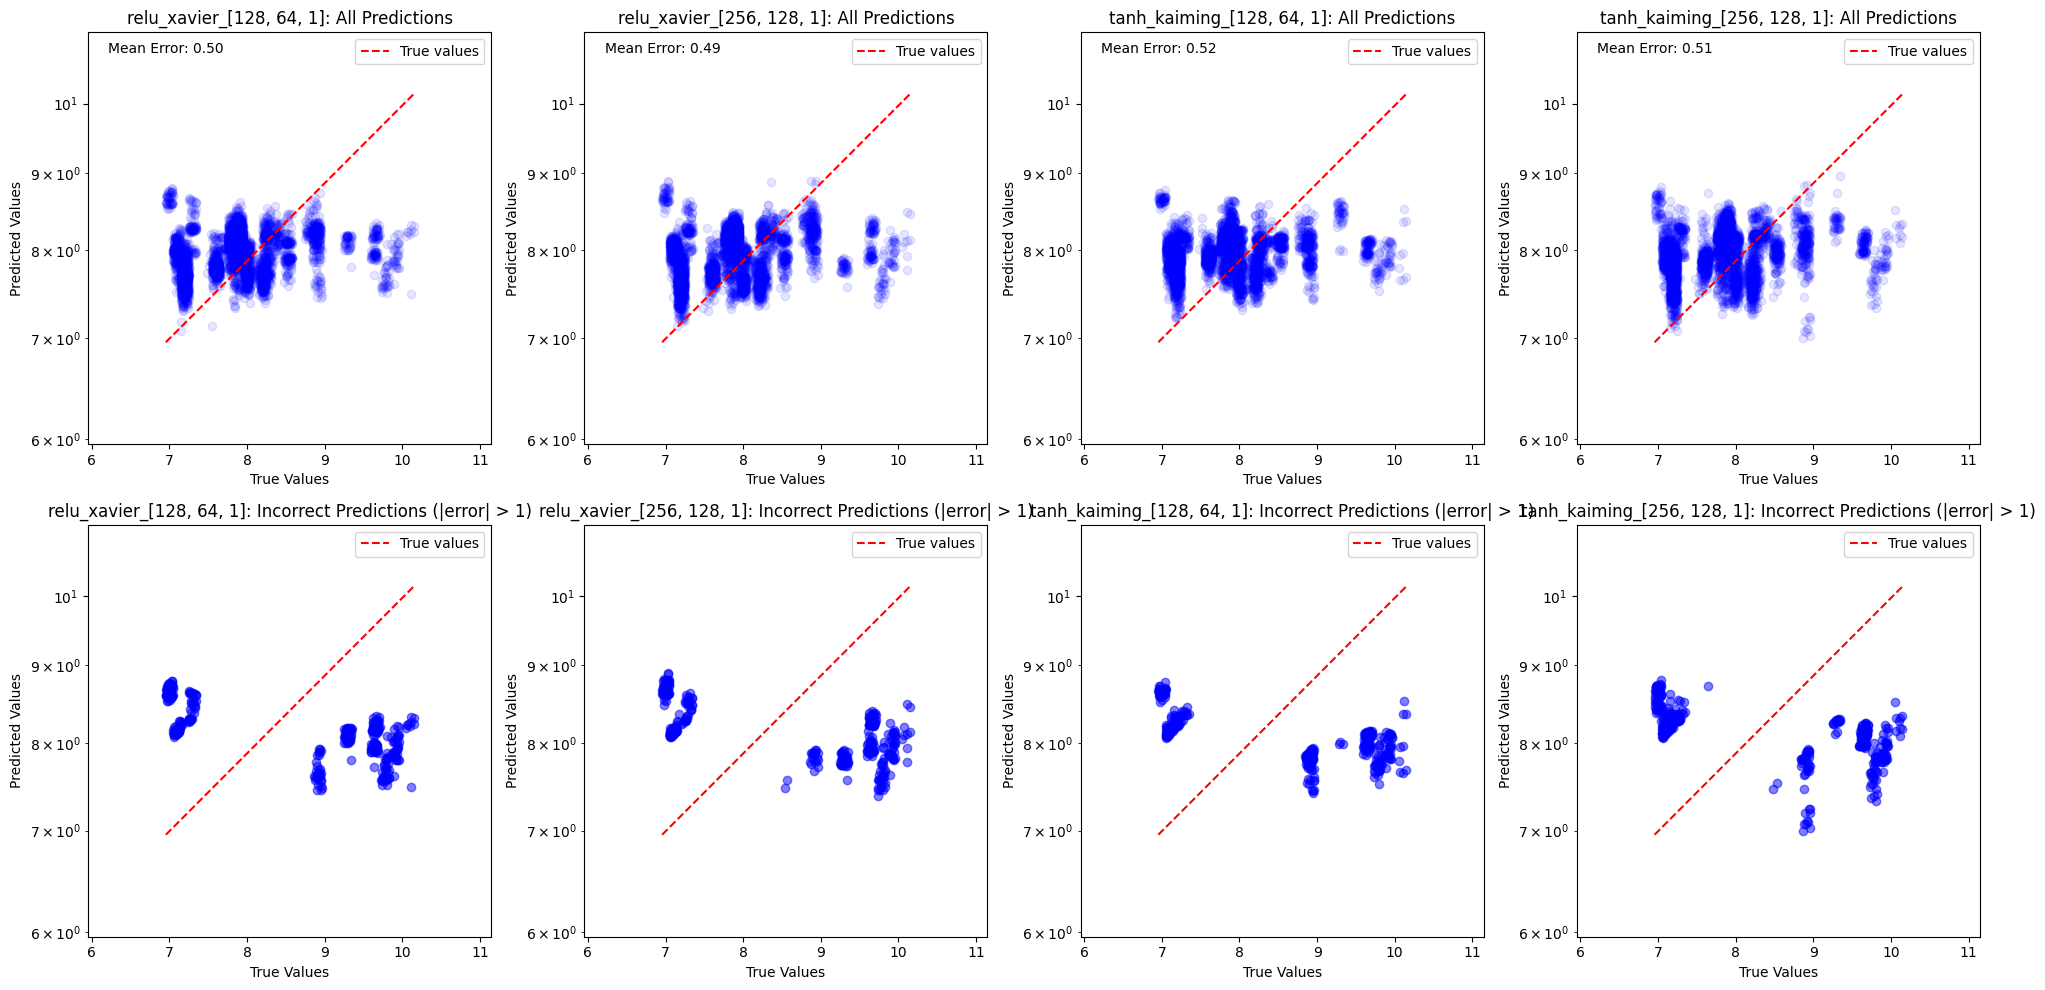

In [90]:
plot_final_models(models, X_valid, y_valid, model_architectures, y_mean=y_mean)

hi
Training model 1/3 with 10 trials
Trial 1/10
    Epoch 1/200, Training Loss: 0.5231, Validation Loss: 0.6014
    Epoch 11/200, Training Loss: 0.3092, Validation Loss: 0.4989
    Epoch 21/200, Training Loss: 0.2964, Validation Loss: 0.4967
    Epoch 31/200, Training Loss: 0.2912, Validation Loss: 0.4957
    Epoch 41/200, Training Loss: 0.2887, Validation Loss: 0.4950
    Epoch 51/200, Training Loss: 0.2874, Validation Loss: 0.4941
    Epoch 61/200, Training Loss: 0.2863, Validation Loss: 0.4913
    Epoch 71/200, Training Loss: 0.2853, Validation Loss: 0.4912
    Epoch 81/200, Training Loss: 0.2845, Validation Loss: 0.4902
    Epoch 91/200, Training Loss: 0.2838, Validation Loss: 0.4892
    Epoch 101/200, Training Loss: 0.2832, Validation Loss: 0.4885
    Epoch 111/200, Training Loss: 0.2827, Validation Loss: 0.4876
    Epoch 121/200, Training Loss: 0.2821, Validation Loss: 0.4867
    Epoch 131/200, Training Loss: 0.2816, Validation Loss: 0.4860
    Epoch 141/200, Training Loss: 0.281

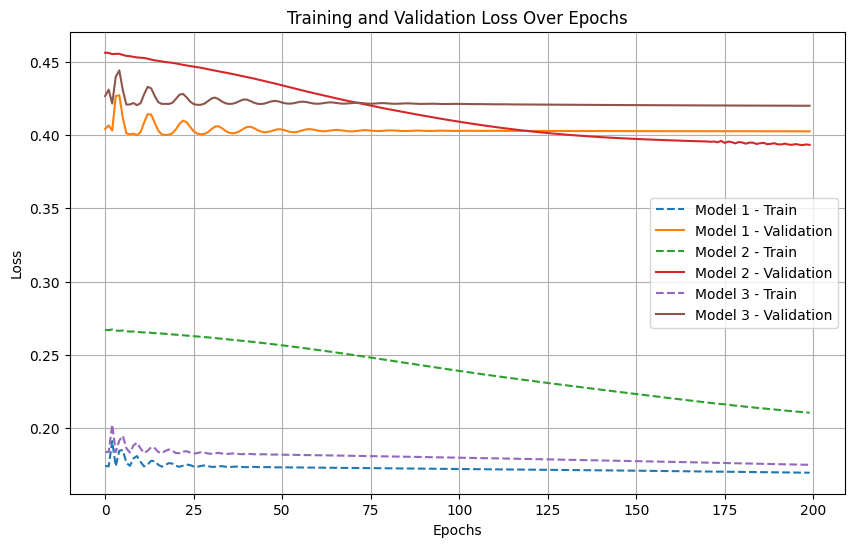

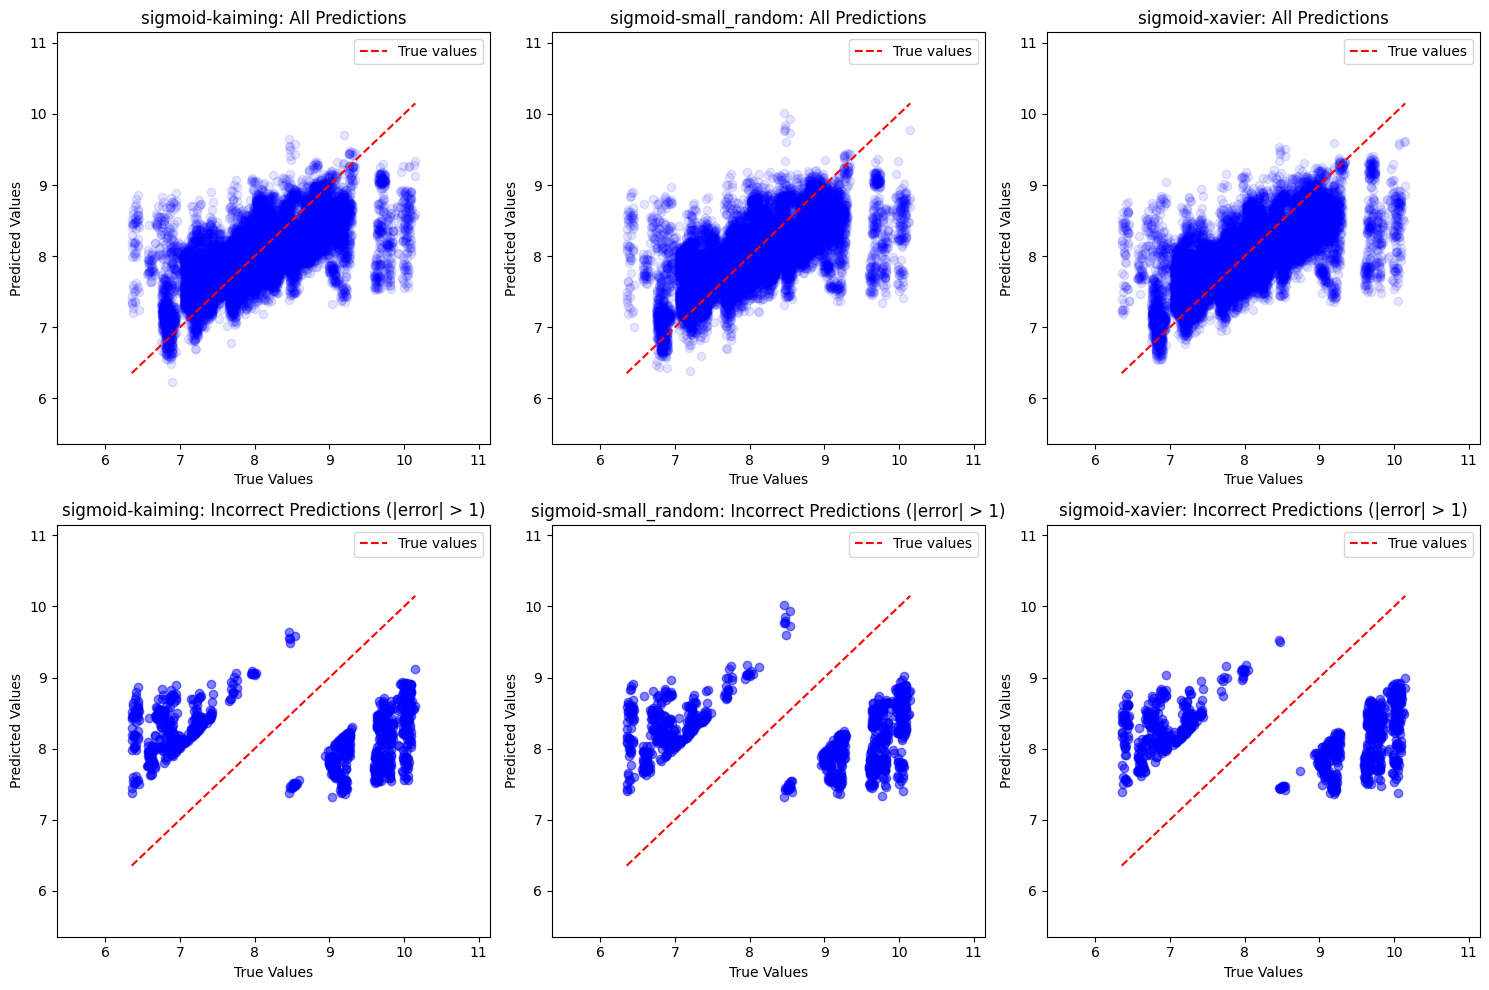

In [49]:

# Example usage:
input_dim = X_train.shape[1]

params1 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "kaiming",
}

params2 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "small_random",
}

params3 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "xavier",
}

# Create model instances
model1 = FlexibleNN(**params1)
model2 = FlexibleNN(**params2)
model3 = FlexibleNN(**params3)

print('hi')
# Train models and plot results
models, loss_arrays, val_loss_arrays = train_multiple_models(
    models=[model3, model2, model1],
    X_train=X_train,  y_train=y_train,
    X_valid=X_valid,  y_valid=y_valid,
    n_epochs=200, lr=0.001,
    loss_fn=torch.nn.MSELoss(),
    plot_results=True,     
    n_trials=10  # Train each model 5 times, keeping the best one
)

models

plot_final_models(models, X_train, y_train, ['sigmoid-kaiming', 'sigmoid-small_random', 'sigmoid-xavier'], y_mean=y_mean)

In [ ]:

# Example usage:
input_dim = X_train.shape[1]

params1 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "kaiming",
}

params2 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "small_random",
}

params3 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "xavier",
}

# Create model instances
model1 = FlexibleNN(**params1)
model2 = FlexibleNN(**params2)
model3 = FlexibleNN(**params3)

print('hi')
# Train models and plot results
models, loss_arrays, val_loss_arrays = train_multiple_models(
    models=[model3, model2, model1],
    X_train=X_train,  y_train=y_train,
    X_valid=X_valid,  y_valid=y_valid,
    n_epochs=200, lr=0.001,
    loss_fn=torch.nn.MSELoss(),
    plot_results=True,     
    n_trials=10  # Train each model 5 times, keeping the best one
)

models

plot_final_models(models, X_train, y_train, ['sigmoid-kaiming', 'sigmoid-small_random', 'sigmoid-xavier'], y_mean=y_mean)

In [31]:
# Plot the Results:

# Try Models W/ Uncertainties:

In [ ]:
# # Test Mutliple Models:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.init as init
# import numpy as np
# from torch.distributions.normal import Normal
# import torch
# import torch.nn as nn
# import torch.nn.init as init


# #Linear Regression W/ Sigma
# class LR_Sigma(nn.Module):
#     def __init__(self, input_dim):
#         super(LinearRegressionWithUncertainty, self).__init__()
#         # Linear layer for predicting the target value
#         self.mean_layer = nn.Linear(input_dim, 1)
#         # Linear layer for predicting the standard deviation (sigma)
#         self.sigma_layer = nn.Linear(input_dim, 1)
        
#     def forward(self, x):
#         mean_pred = self.mean_layer(x)
#         sigma_pred = torch.exp(self.sigma_layer(x))  # Ensure that sigma is positive by exponentiating
#         return mean_pred, sigma_pred

# class SimpleNN_3Layer_RELU_NoSigma(nn.Module):
#     def __init__(self, input_dim, x1, x2, init_method="xavier"):
#         super(SimpleNN_3Layer_RELU, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.fc3 = nn.Linear(x2, 1)  # Output layer

#         # Apply chosen initialization method
#         self.init_method = init_method.lower()
#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         """Custom weight initialization function."""
#         if isinstance(m, nn.Linear):
#             if self.init_method == "kaiming":
#                 init.kaiming_normal_(m.weight, nonlinearity='relu')
#             elif self.init_method == "xavier":
#                 init.xavier_normal_(m.weight)
#             elif self.init_method == "small_random":
#                 init.normal_(m.weight, mean=0.0, std=0.01)
#             elif self.init_method == "orthogonal":
#                 init.orthogonal_(m.weight)
#             elif self.init_method == "hybrid":
#                 if m in [self.fc1, self.fc2]:
#                     init.kaiming_normal_(m.weight, nonlinearity='relu')
#                 else:
#                     init.xavier_normal_(m.weight)

#             init.zeros_(m.bias)  # Initialize biases to zero

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         y_pred = self.fc3(x)  # Single output
#         return y_pred


# # Simple NN with sigma output

# class SimpleNN_3Layer_RELU(nn.Module):
#     def __init__(self, input_dim, x1, x2, init_method="xavier"):
#         super(SimpleNN_3Layer_RELU, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.fc3_mean = nn.Linear(x2, 1)  # Output: Mean prediction
#         self.fc3_log_sigma = nn.Linear(x2, 1)  # Output: Log variance prediction

#         # Apply chosen initialization method
#         self.init_method = init_method.lower()
#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         """Custom weight initialization function."""
#         if isinstance(m, nn.Linear):
#             if self.init_method == "kaiming":
#                 init.kaiming_normal_(m.weight, nonlinearity='relu')
#             elif self.init_method == "xavier":
#                 init.xavier_normal_(m.weight)
#             elif self.init_method == "small_random":
#                 init.normal_(m.weight, mean=0.0, std=0.01)
#             elif self.init_method == "orthogonal":
#                 init.orthogonal_(m.weight)
#             elif self.init_method == "hybrid":
#                 if m in [self.fc1, self.fc2]:
#                     init.kaiming_normal_(m.weight, nonlinearity='relu')
#                 else:
#                     init.xavier_normal_(m.weight)

#             init.zeros_(m.bias)  # Initialize biases to zero

#             # Special handling for log_sigma layer
#             if m is self.fc3_log_sigma:
#                 m.bias.data.fill_(-3)  # Helps prevent large initial sigma values

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         y_pred = self.fc3_mean(x)  # Mean output
#         log_sigma_pred = self.fc3_log_sigma(x)  # Log variance output
#         sigma_pred = torch.exp(log_sigma_pred)  # Ensure sigma is positive
#         return y_pred, sigma_pred

# class SimpleNN_3Layer_Sigmoid(nn.Module):
#     def __init__(self, input_dim, x1, x2):
#         super(SimpleNN_3Layer_Sigmoid, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.fc3_mean = nn.Linear(x2, 1)  # Output: Mean prediction
#         self.fc3_log_sigma = nn.Linear(x2, 1)  # Output: Log variance prediction

#     def forward(self, x):
#         x = torch.sigmoid(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         y_pred = self.fc3_mean(x)  # Mean output
#         log_sigma_pred = self.fc3_log_sigma(x)  # Log variance output
#         sigma_pred = torch.exp(log_sigma_pred)  # Important that sigma is positive
#         #print("    median y, sigma: ", torch.median(y_pred), torch.median(sigma_pred))
#         return y_pred, sigma_pred

# class SimpleNN_4Layer_RELU(nn.Module):
#     def __init__(self, input_dim, x1, x2, x3):
#         super(SimpleNN_4Layer_RELU, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.fc3 = nn.Linear(x2, x3)  # Hidden layer
#         self.fc4_mean = nn.Linear(x3, 1)  # Output: Mean prediction
#         self.fc4_log_sigma = nn.Linear(x3, 1)  # Output: Log variance prediction

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         y_pred = self.fc4_mean(x)  # Mean output
#         log_sigma_pred = self.fc4_log_sigma(x)  # Log variance output
#         sigma_pred = torch.exp(log_sigma_pred)  # Ensure sigma is positive
#         return y_pred, sigma_pred

# class SimpleNN_5Layer_RELU(nn.Module):
#     def __init__(self, input_dim, x1, x2, x3, x4):
#         super(SimpleNN_5Layer_RELU, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.fc3 = nn.Linear(x2, x3)  # Hidden layer
#         self.fc4 = nn.Linear(x3, x4)  # Hidden layer
#         self.fc5_mean = nn.Linear(x4, 1)  # Output: Mean prediction
#         self.fc5_log_sigma = nn.Linear(x4, 1)  # Output: Log variance prediction

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.relu(self.fc4(x))
#         y_pred = self.fc5_mean(x)  # Mean output
#         log_sigma_pred = self.fc5_log_sigma(x)  # Log variance output
#         sigma_pred = torch.exp(log_sigma_pred)  # Ensure sigma is positive
#         return y_pred, sigma_pred


# def calc_median_sigma(model, validation_set):
#     # Evaluate model and get predictions
#     model.eval()
#     with torch.no_grad():
#         y_pred_test, sigma_pred_test = model(validation_set)
#     return torch.median(sigma_pred_test)

# def calc_Loss_Components(model, validation_X, y_true):
#     # Evaluate model and get predictions
#     model.eval()
#     with torch.no_grad():
#         y_pred, sigma_pred = model(validation_X)
        
#     return 0.5 * torch.mean(((y_true - y_pred) ** 2) / (sigma_pred ** 2)), 0.5 * torch.mean(torch.log(sigma_pred))


# # Define the GaussianNLLLoss class
# class GaussianNLLLoss_ME(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, y_pred, y_true, sigma_pred):
#         sigma_pred = torch.clamp(sigma_pred, min=1e-6)  # Avoid log(0)
#         loss = 0.5 * (((y_true - y_pred) ** 2) / (sigma_pred ** 2) +  torch.log(sigma_pred))

#         if False:
#             print(torch.min(y_true), torch.min(y_pred), torch.min(sigma_pred))
#         return loss.mean()

